# Import

In [1]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from my_ml_lib import DataManipulationTools, MetricTools, PlotTools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Import different classifiers
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

# Functions

## Write CSV

In [4]:
def write_csv(file, a1, a2, a3, a4, a5, a6, a7, name):
    with open(file, mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(name)
        for i in range(20):
            if a2[i] == None:
                a2[i] = 'None'
            if a4[i] == None:
                a4[i] = 'None'
            csv_writer.writerow([a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i]])

## Read dataset:

In [5]:
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

## Save / Load Extracted Features:

In [6]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

## Save / Load Trained Model:

In [7]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

## Features:

### Flattened Image:

In [8]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

### Color Histograms:

In [9]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

### HOG based Features:

In [10]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2') for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

### KAZE based features:

In [11]:
def get_kaze(images, name='kaze', save=False):
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### SIFT based Features:

In [12]:
def get_sift(images, name='sift', save=False):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [13]:
def return_sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### SURF based Features:

In [14]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [15]:
def return_surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### LBP Feature:

In [16]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

### Combine Features:

In [17]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

### Normalize features:

In [18]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [19]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

## Classifiers:

In [168]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['NB', 'SVM', 'XGB', 'MLP', 'ADA', 'BAG', 'RF']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

## ROC

In [217]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [333]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

## CM

In [23]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

## PCA projected data

In [24]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,20))
    for i, img in enumerate(mat, start=1):
        plt.subplot(4, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

In [25]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

# Main calls

## Read and split data

### Read and Store

In [22]:
full_data_x, full_data_y = read_images('cell_images')

In [23]:
full_data_x.shape, full_data_y.shape

((27558, 32, 32, 3), (27558,))

In [24]:
full_data_x[2].shape

(32, 32, 3)

In [25]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [26]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [27]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)

In [28]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [ ]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

np.save('data/data_x.npy', data_x)
np.save('data/data_y.npy', data_y)
np.save('data/test_x.npy', test_x)
np.save('data/test_y.npy', test_y)

### Load

In [26]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

data_x = np.load('data/data_x.npy')
data_y = np.load('data/data_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')

In [27]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [28]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

## Training:


### Training & Validation set features:

#### Data visualization:

In [346]:
infected_img = train_imgs[train_y == 0][8]
uninfected_img = train_imgs[train_y == 1][4]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [347]:
vis_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
sift = np.zeros((2, 32, 32, 3), dtype='uint8')
surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, vis_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_sift_kp(classes[i]))
    surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_surf_kp(classes[i]))

In [348]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(vis_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
for i in range(len(classes)):
    data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
for i in range(len(classes)):
    img_name_arr.append('SURF')

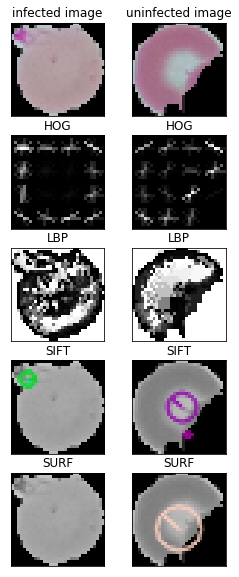

In [351]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()

#### HOG Features:

In [29]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [30]:
hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

In [31]:
hog_train.shape, hog_val.shape

((17636, 324), (4410, 324))

#### LBP Features:

In [32]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [33]:
lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

In [34]:
lbp_train.shape, lbp_val.shape

((17636, 1024), (4410, 1024))

#### KAZE Features:

In [36]:
kaze_train = get_kaze(train_imgs, name='kaze_train', save=True)
kaze_val = get_kaze(val_imgs, name='kaze_val', save=True)

Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [37]:
kaze_train = load_feature('cache/kaze_train.pkl')
kaze_val = load_feature('cache/kaze_val.pkl')

In [38]:
kaze_train.shape, kaze_val.shape

((17636, 2048), (4410, 2048))

#### SIFT Features:

In [39]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [40]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [41]:
sift_train.shape, sift_val.shape

((17636, 1920), (4410, 1920))

#### SURF Features:

In [44]:
surf_train = get_surf(train_imgs, name='surf_train', save=True)
surf_val = get_surf(val_imgs, name='surf_val', save=True)

Feature saved with name cache/surf_train.pkl
Feature saved with name cache/surf_val.pkl


In [45]:
surf_train = load_feature('cache/surf_train.pkl')
surf_val = load_feature('cache/surf_val.pkl')

In [46]:
surf_train.shape, surf_val.shape

((17636, 256), (4410, 256))

#### Flattened Image

##### RGB:

In [47]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [48]:
flat_rgb_train = load_feature('cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('cache/flat_rgb_val.pkl')

In [49]:
flat_rgb_train.shape, flat_rgb_val.shape

((17636, 3072), (4410, 3072))

##### GRAY:

In [50]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [51]:
flat_gray_train = load_feature('cache/flat_gray_train.pkl')
flat_gray_val = load_feature('cache/flat_gray_val.pkl')

In [52]:
flat_gray_train.shape, flat_gray_val.shape

((17636, 1024), (4410, 1024))

#### Color Histogram:

In [53]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [54]:
hist_train = load_feature('cache/hist_train.pkl')
hist_val = load_feature('cache/hist_val.pkl')

In [55]:
hist_train.shape, hist_val.shape

((17636, 512), (4410, 512))

### Reduce Features by PCA:

#### HOG Features:

In [56]:
# norm_hog_train, norm_hog_val = norm_features_minmax(hog_train, hog_val)
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [57]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [58]:
np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

In [59]:
pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

In [60]:
pca_hog_train.shape, pca_hog_val.shape

((17636, 10), (4410, 10))

#### LBP Features:

In [61]:
# norm_lbp_train, norm_lbp_val = norm_features_minmax(lbp_train, lbp_val)
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [62]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [63]:
np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

In [64]:
pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

In [65]:
pca_lbp_train.shape, pca_lbp_val.shape

((17636, 10), (4410, 10))

#### KAZE Features:

In [66]:
# norm_kaze_train, norm_kaze_val = norm_features_minmax(kaze_train, kaze_val)
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

In [67]:
pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

In [68]:
np.save('cache/pca_kaze_train.npy', pca_kaze_train)
np.save('cache/pca_kaze_val.npy', pca_kaze_val)

In [69]:
pca_kaze_train = np.load('cache/pca_kaze_train.npy')
pca_kaze_val = np.load('cache/pca_kaze_val.npy')

In [70]:
pca_kaze_train.shape, pca_kaze_val.shape

((17636, 10), (4410, 10))

#### SIFT Features:

In [71]:
# norm_sift_train, norm_sift_val = norm_features_minmax(sift_train, sift_val)
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

In [72]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

In [73]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

In [74]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

In [75]:
pca_sift_train.shape, pca_sift_val.shape

((17636, 5), (4410, 5))

#### SURF Features:

In [76]:
# norm_surf_train, norm_surf_val = norm_features_minmax(surf_train, surf_val)
norm_surf_train, norm_surf_val = norm_features_zscore(surf_train, surf_val)

In [77]:
pca = PCA(n_components=5)
pca_surf_train = pca.fit_transform(norm_surf_train)
pca_surf_val = pca.transform(norm_surf_val)

In [79]:
np.save('cache/pca_surf_train.npy', pca_surf_train)
np.save('cache/pca_surf_val.npy', pca_surf_val)

In [80]:
pca_surf_train = np.load('cache/pca_surf_train.npy')
pca_surf_val = np.load('cache/pca_surf_val.npy')

In [81]:
pca_surf_train.shape, pca_surf_val.shape

((17636, 5), (4410, 5))

#### Flattened Image

##### RGB:

In [82]:
# norm_flat_rgb_train, norm_flat_rgb_val = norm_features_minmax(flat_rgb_train, flat_rgb_val)
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [83]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [85]:
np.save('cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [86]:
pca_flat_rgb_train = np.load('cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('cache/pca_flat_rgb_val.npy')

In [87]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((17636, 10), (4410, 10))

##### GRAY:

In [88]:
# norm_flat_gray_train, norm_flat_gray_val = norm_features_minmax(flat_gray_train, flat_gray_val)
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [89]:
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [91]:
np.save('cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('cache/pca_flat_gray_val.npy', pca_flat_gray_val)

In [92]:
pca_flat_gray_train = np.load('cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('cache/pca_flat_gray_val.npy')

In [93]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((17636, 6), (4410, 6))

#### Color Histogram:

In [94]:
# norm_hist_train, norm_hist_val = norm_features_minmax(hist_train, hist_val)
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [95]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [97]:
np.save('cache/pca_hist_train.npy', pca_hist_train)
np.save('cache/pca_hist_val.npy', pca_hist_val)

In [98]:
pca_hist_train = np.load('cache/pca_hist_train.npy')
pca_hist_val = np.load('cache/pca_hist_val.npy')

In [99]:
pca_hist_train.shape, pca_hist_val.shape

((17636, 10), (4410, 10))

### Feature PCA variance comparison:

In [220]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
pca_array.append(pca_sift_train)
pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)
len(pca_array)

8

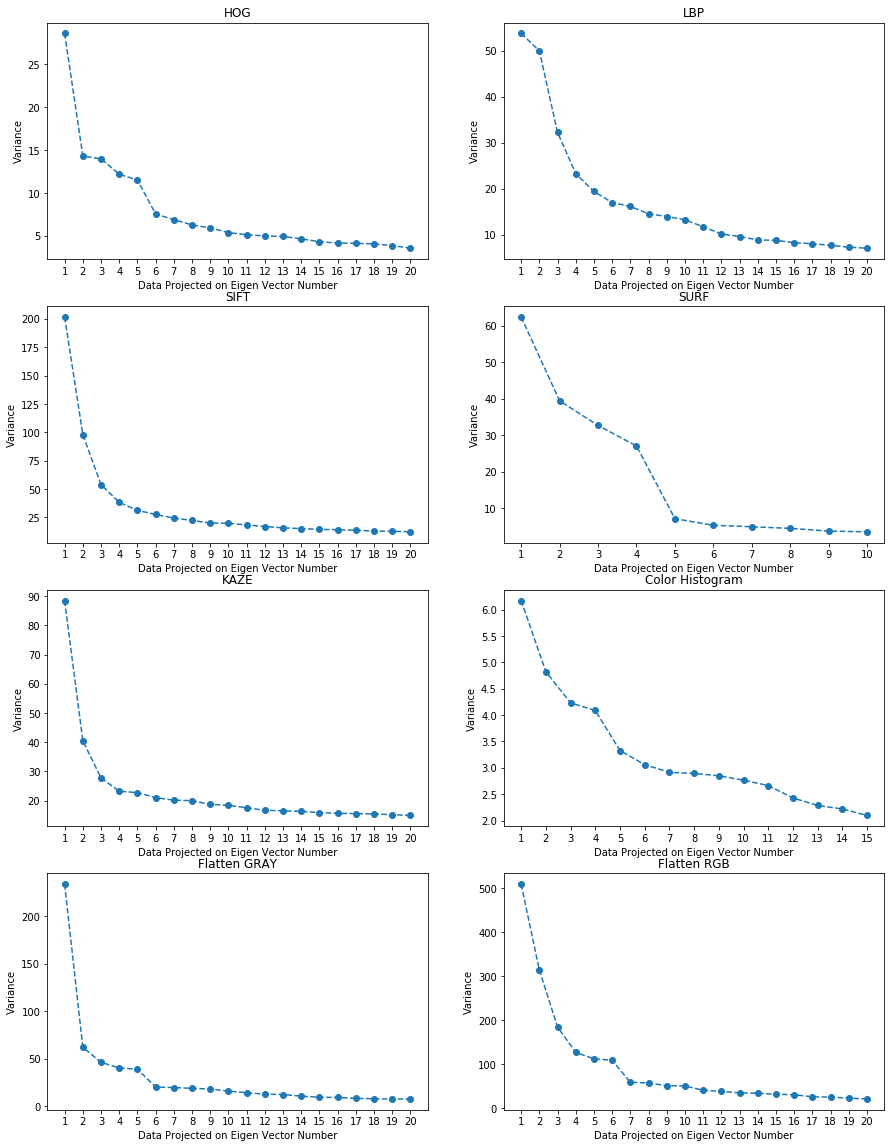

In [221]:
pca_projection(pca_array, ['HOG', 'LBP', 'SIFT', 'SURF', 'KAZE', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

### Reduce Features by LDA:

#### HOG Features:

In [100]:
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)

In [101]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [102]:
np.save('cache/lda_hog_train.npy', lda_hog_train)
np.save('cache/lda_hog_val.npy', lda_hog_val)

In [103]:
lda_hog_train = np.load('cache/lda_hog_train.npy')
lda_hog_val = np.load('cache/lda_hog_val.npy')

In [104]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

#### LBP Features:

In [105]:
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)

In [107]:
np.save('cache/lda_lbp_train.npy', lda_lbp_train)
np.save('cache/lda_lbp_val.npy', lda_lbp_val)

In [108]:
lda_lbp_train = np.load('cache/lda_lbp_train.npy')
lda_lbp_val = np.load('cache/lda_lbp_val.npy')

In [109]:
lda_lbp_train.shape, lda_lbp_val.shape

((17636, 1), (4410, 1))

#### SIFT

In [110]:
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)

/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [112]:
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)

In [113]:
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

In [114]:
lda_sift_train.shape, lda_sift_val.shape

((17636, 1), (4410, 1))

#### Color Histogram:

In [115]:
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)

/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [116]:
np.save('cache/lda_hist_train.npy', lda_hist_train)
np.save('cache/lda_hist_val.npy', lda_hist_val)

In [117]:
lda_hist_train = np.load('cache/lda_hist_train.npy')
lda_hist_val = np.load('cache/lda_hist_val.npy')

In [118]:
lda_hist_train.shape, lda_hist_val.shape

((17636, 1), (4410, 1))

### Combine Features normal:

In [ ]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train, surf_train, flat_rgb_train, lbp_train, kaze_train, sift_train], 
                  [hog_val, hist_val, surf_val, flat_rgb_val, lbp_val, kaze_val, sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [ ]:
features_train.shape, features_val.shape

### Combine Features PCA:

In [119]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train, pca_sift_train, pca_flat_rgb_train, pca_hist_train], 
                  [pca_hog_val, pca_lbp_val, pca_sift_val, pca_flat_rgb_val, pca_hist_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [120]:
features_train.shape, features_val.shape

((17636, 45), (4410, 45))

### Combine Features LDA:

In [121]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train, lda_sift_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val, lda_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [123]:
features_train_lda.shape, features_val_lda.shape

((17636, 4), (4410, 4))

### LDA on PCA

In [162]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

In [163]:
np.save('cache/lda_on_pca_train.npy', lda_on_pca_train)
np.save('cache/lda_on_pca_val.npy', lda_on_pca_val)

In [164]:
lda_on_pca_train = np.load('cache/lda_on_pca_train.npy')
lda_on_pca_val = np.load('cache/lda_on_pca_val.npy')

In [165]:
lda_on_pca_train.shape, lda_on_pca_val.shape

((17636, 1), (4410, 1))

### Combine Features:

In [330]:
features_t = pca_hist_train
features_v = pca_hist_val

In [331]:
features_t.shape, features_v.shape

((17636, 10), (4410, 10))

### Classification:

### PCA

In [183]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.8857142857142857
[[1954  257]
 [ 247 1952]]
Recall in 'RF' = 0.8837630031659882
Precision in 'RF' = 0.8877782825988187
F1 Score in 'RF' = 0.8857660924750681


In [318]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [184]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.8913832199546485
[[1981  230]
 [ 249 1950]]
Recall in 'BAG' = 0.8959746720940751
Precision in 'BAG' = 0.888340807174888
F1 Score in 'BAG' = 0.8921414095924342


In [308]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [185]:
model3 = train_model(features_train, train_y, model_name='ADA', validation=(features_val, val_y))

Validation Accuracy in 'ADA' = 0.8748299319727891
[[1910  301]
 [ 251 1948]]
Recall in 'ADA' = 0.8638625056535504
Precision in 'ADA' = 0.8838500694123091
F1 Score in 'ADA' = 0.8737419945105215


In [309]:
prob3 = model3.predict_proba(features_val)
prob30 = prob3[:,0].reshape(prob3.shape[0], 1)
prob31 = prob3[:,1].reshape(prob3.shape[0], 1)

In [186]:
model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6668934240362812
[[ 934 1277]
 [ 192 2007]]
Recall in 'NB' = 0.4224332881049299
Precision in 'NB' = 0.8294849023090586
F1 Score in 'NB' = 0.5597842373389272


In [310]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [187]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.8702947845804989
[[1883  328]
 [ 244 1955]]
Recall in 'SVM' = 0.8516508367254636
Precision in 'SVM' = 0.8852844381758345
F1 Score in 'SVM' = 0.8681420009220839


In [311]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [188]:
model6 = train_model(np.array(features_train), train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.9149659863945578
[[2003  208]
 [ 167 2032]]
Recall in 'XGB' = 0.905924920850294
Precision in 'XGB' = 0.9230414746543779
F1 Score in 'XGB' = 0.9144031043140836


In [312]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [189]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.7764172335600907
[[1598  613]
 [ 373 1826]]
Recall in 'KNN' = 0.7227498869289914
Precision in 'KNN' = 0.8107559614408929
F1 Score in 'KNN' = 0.7642276422764227


In [313]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

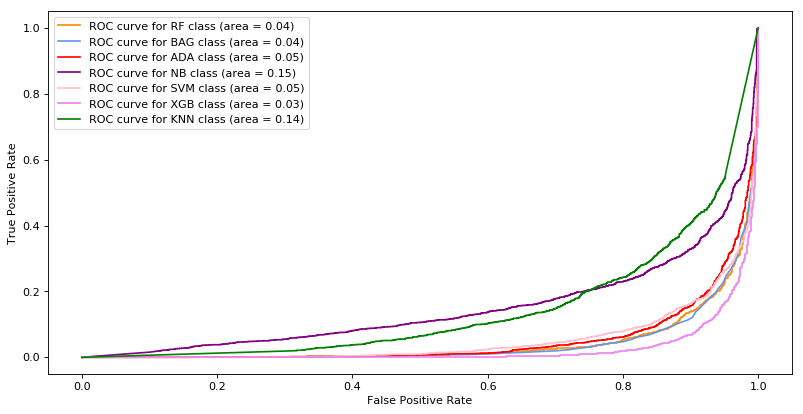

In [322]:
prob = np.concatenate((prob10, prob20, prob30, prob40, prob50, prob60, prob70), axis=1)
plot_combine_roc(val_y, prob)

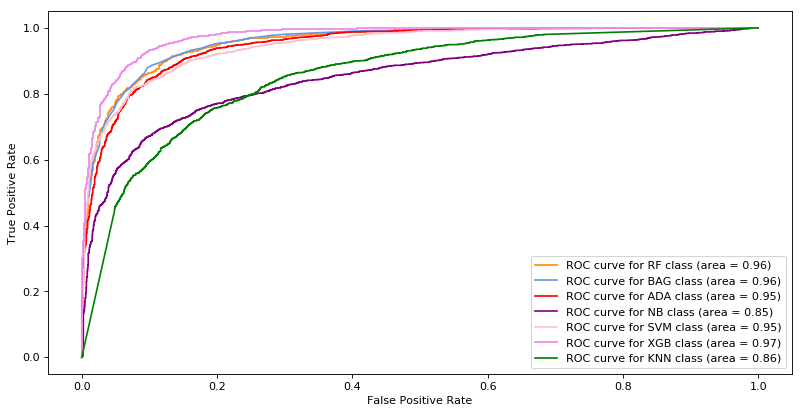

In [324]:
prob = np.concatenate((prob11, prob21, prob31, prob41, prob51, prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

### LDA

In [174]:
model8 = train_model(features_train_lda, train_y, model_name='RF', validation=(features_val_lda, val_y))

Validation Accuracy in 'RF' = 0.8648526077097506
[[1903  308]
 [ 288 1911]]
Recall in 'RF' = 0.8606965174129353
Precision in 'RF' = 0.8685531720675491
F1 Score in 'RF' = 0.8646069968196274


In [287]:
prob8 = model8.predict_proba(features_val_lda)
prob80 = prob8[:,0].reshape(prob8.shape[0], 1)
prob81 = prob8[:,1].reshape(prob8.shape[0], 1)

In [175]:
model9 = train_model(features_train_lda, train_y, model_name='BAG', validation=(features_val_lda, val_y))

Validation Accuracy in 'BAG' = 0.8546485260770975
[[1877  334]
 [ 307 1892]]
Recall in 'BAG' = 0.8489371325192221
Precision in 'BAG' = 0.8594322344322345
F1 Score in 'BAG' = 0.8541524459613197


In [288]:
prob9 = model9.predict_proba(features_val_lda)
prob90 = prob9[:,0].reshape(prob9.shape[0], 1)
prob91 = prob9[:,1].reshape(prob9.shape[0], 1)

In [176]:
model10 = train_model(features_train_lda, train_y, model_name='ADA', validation=(features_val_lda, val_y))

Validation Accuracy in 'ADA' = 0.8650793650793651
[[1887  324]
 [ 271 1928]]
Recall in 'ADA' = 0.8534599728629579
Precision in 'ADA' = 0.8744207599629287
F1 Score in 'ADA' = 0.8638132295719845


In [289]:
prob10 = model10.predict_proba(features_val_lda)
prob100 = prob10[:,0].reshape(prob10.shape[0], 1)
prob101 = prob10[:,1].reshape(prob10.shape[0], 1)

In [177]:
model11 = train_model(features_train_lda, train_y, model_name='NB', validation=(features_val_lda, val_y))

Validation Accuracy in 'NB' = 0.8514739229024944
[[1810  401]
 [ 254 1945]]
Recall in 'NB' = 0.8186341022161918
Precision in 'NB' = 0.876937984496124
F1 Score in 'NB' = 0.8467836257309942


In [290]:
prob11 = model11.predict_proba(features_val_lda)
prob110 = prob11[:,0].reshape(prob11.shape[0], 1)
prob111 = prob11[:,1].reshape(prob11.shape[0], 1)

In [178]:
model12 = train_model(features_train_lda, train_y, model_name='SVM', validation=(features_val_lda, val_y))

Validation Accuracy in 'SVM' = 0.8682539682539683
[[1941  270]
 [ 311 1888]]
Recall in 'SVM' = 0.8778833107191316
Precision in 'SVM' = 0.8619005328596803
F1 Score in 'SVM' = 0.8698185077302263


In [291]:
prob12 = model12.predict_proba(features_val_lda)
prob120 = prob12[:,0].reshape(prob12.shape[0], 1)
prob121 = prob12[:,1].reshape(prob12.shape[0], 1)

In [179]:
model13 = train_model(features_train_lda, train_y, model_name='XGB', validation=(features_val_lda, val_y))

Validation Accuracy in 'XGB' = 0.8607709750566893
[[1883  328]
 [ 286 1913]]
Recall in 'XGB' = 0.8516508367254636
Precision in 'XGB' = 0.8681420009220839
F1 Score in 'XGB' = 0.8598173515981735


In [292]:
prob13 = model13.predict_proba(features_val_lda)
prob130 = prob13[:,0].reshape(prob13.shape[0], 1)
prob131 = prob13[:,1].reshape(prob13.shape[0], 1)

In [180]:
model14 = train_model(features_train_lda, train_y, model_name='KNN', validation=(features_val_lda, val_y))

Validation Accuracy in 'KNN' = 0.8507936507936508
[[1884  327]
 [ 331 1868]]
Recall in 'KNN' = 0.8521031207598372
Precision in 'KNN' = 0.8505643340857788
F1 Score in 'KNN' = 0.851333032083145


In [293]:
prob14 = model14.predict_proba(features_val_lda)
prob140 = prob14[:,0].reshape(prob14.shape[0], 1)
prob141 = prob14[:,1].reshape(prob14.shape[0], 1)

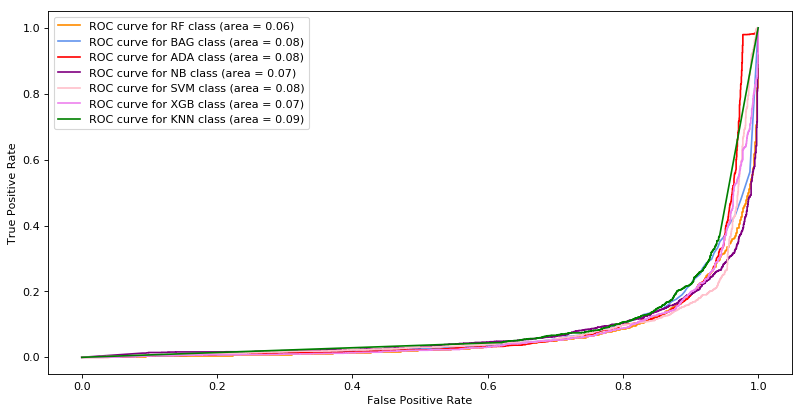

In [328]:
prob = np.concatenate((prob80, prob90, prob100, prob110, prob120, prob130, prob140), axis=1)
plot_combine_roc(val_y, prob)

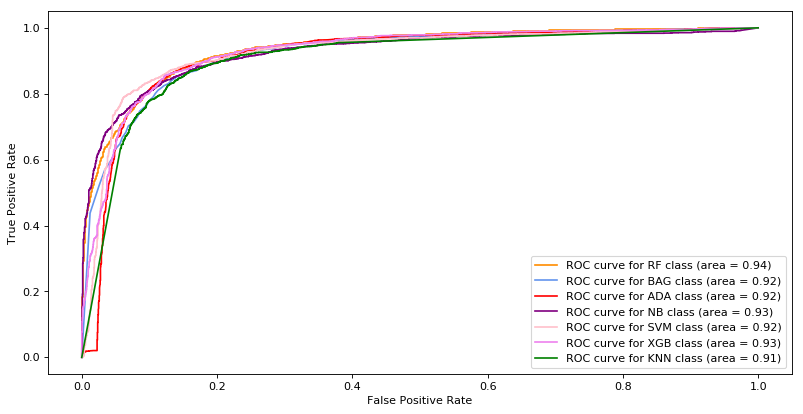

In [326]:
prob = np.concatenate((prob81, prob91, prob101, prob111, prob121, prob131, prob141), axis=1)
plot_combine_roc(val_y, prob)

### LDA on PCA

In [181]:
model15 = train_model(lda_on_pca_train, train_y, model_name='RF', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'RF' = 0.8360544217687075
[[1903  308]
 [ 415 1784]]
Recall in 'RF' = 0.8606965174129353
Precision in 'RF' = 0.8209663503019845
F1 Score in 'RF' = 0.8403621108412455


In [297]:
prob15 = model15.predict_proba(lda_on_pca_val)
prob150 = prob15[:,0].reshape(prob15.shape[0], 1)
prob151 = prob15[:,1].reshape(prob15.shape[0], 1)

In [182]:
model16 = train_model(lda_on_pca_train, train_y, model_name='BAG', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'BAG' = 0.7691609977324263
[[1695  516]
 [ 502 1697]]
Recall in 'BAG' = 0.7666214382632293
Precision in 'BAG' = 0.7715065999089668
F1 Score in 'BAG' = 0.7690562613430127


In [298]:
prob16 = model16.predict_proba(lda_on_pca_val)
prob160 = prob16[:,0].reshape(prob16.shape[0], 1)
prob161 = prob16[:,1].reshape(prob16.shape[0], 1)

In [169]:
model17 = train_model(lda_on_pca_train, train_y, model_name='ADA', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'ADA' = 0.8380952380952381
[[1917  294]
 [ 420 1779]]
Recall in 'ADA' = 0.8670284938941656
Precision in 'ADA' = 0.8202824133504493
F1 Score in 'ADA' = 0.8430079155672824


In [299]:
prob17 = model17.predict_proba(lda_on_pca_val)
prob170 = prob17[:,0].reshape(prob17.shape[0], 1)
prob171 = prob17[:,1].reshape(prob17.shape[0], 1)

In [170]:
model18 = train_model(lda_on_pca_train, train_y, model_name='NB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'NB' = 0.8217687074829932
[[1675  536]
 [ 250 1949]]
Recall in 'NB' = 0.7575757575757576
Precision in 'NB' = 0.8701298701298701
F1 Score in 'NB' = 0.8099613152804642


In [300]:
prob18 = model18.predict_proba(lda_on_pca_val)
prob180 = prob18[:,0].reshape(prob18.shape[0], 1)
prob181 = prob18[:,1].reshape(prob18.shape[0], 1)

In [171]:
model19 = train_model(lda_on_pca_train, train_y, model_name='SVM', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'SVM' = 0.8365079365079365
[[1880  331]
 [ 390 1809]]
Recall in 'SVM' = 0.8502939846223428
Precision in 'SVM' = 0.8281938325991189
F1 Score in 'SVM' = 0.8390984155322474


In [301]:
prob19 = model19.predict_proba(lda_on_pca_val)
prob190 = prob19[:,0].reshape(prob19.shape[0], 1)
prob191 = prob19[:,1].reshape(prob19.shape[0], 1)

In [172]:
model20 = train_model(lda_on_pca_train, train_y, model_name='XGB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'XGB' = 0.8383219954648526
[[1904  307]
 [ 406 1793]]
Recall in 'XGB' = 0.8611488014473089
Precision in 'XGB' = 0.8242424242424242
F1 Score in 'XGB' = 0.8422915284229152


In [302]:
prob20 = model20.predict_proba(lda_on_pca_val)
prob200 = prob20[:,0].reshape(prob20.shape[0], 1)
prob201 = prob20[:,1].reshape(prob20.shape[0], 1)

In [173]:
model21 = train_model(lda_on_pca_train, train_y, model_name='KNN', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'KNN' = 0.7934240362811792
[[1756  455]
 [ 456 1743]]
Recall in 'KNN' = 0.7942107643600181
Precision in 'KNN' = 0.7938517179023508
F1 Score in 'KNN' = 0.7940312005426181


In [303]:
prob21 = model21.predict_proba(lda_on_pca_val)
prob210 = prob21[:,0].reshape(prob21.shape[0], 1)
prob211 = prob21[:,1].reshape(prob21.shape[0], 1)

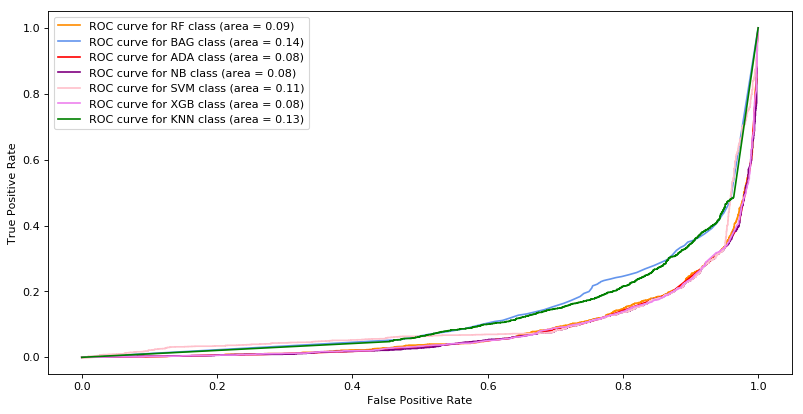

In [330]:
prob = np.concatenate((prob150, prob160, prob170, prob180, prob190, prob200, prob210), axis=1)
plot_combine_roc(val_y, prob)

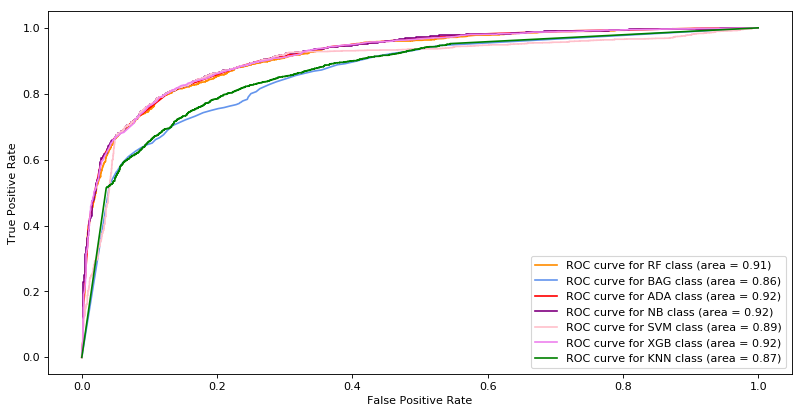

In [332]:
prob = np.concatenate((prob151, prob161, prob171, prob181, prob191, prob201, prob211), axis=1)
plot_combine_roc(val_y, prob)

## Testing

In [190]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
lbp_comp_train = combine_features([lbp_train, lbp_val], horizontal=False)
kaze_comp_train = combine_features([kaze_train, kaze_val], horizontal=False)
sift_comp_train = combine_features([sift_train, sift_val], horizontal=False)
surf_comp_train = combine_features([surf_train, surf_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [191]:
data_y = np.hstack([train_y, val_y])

In [192]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=30)
pca_lbp_comp_train = pca.fit_transform(lbp_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_kaze_comp_train = pca.fit_transform(kaze_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=15)
pca_sift_comp_train = pca.fit_transform(sift_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=5)
pca_surf_comp_train = pca.fit_transform(surf_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

In [193]:
reduced_train_features=[pca_hog_comp_train,
                        pca_lbp_comp_train,
                        pca_kaze_comp_train,
                        pca_sift_comp_train,
                        pca_surf_comp_train,
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [194]:
hog_test = get_hog(test_x, name='hog_test', save=True)
lbp_test = get_lbp(test_x, name='lbp_test', save=True)
kaze_test = get_kaze(test_x, name='kaze_test', save=True)
sift_test = get_sift(test_x, name='sift_test', save=True)
surf_test = get_surf(test_x, name='surf_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/lbp_test.pkl
Feature saved with name cache/kaze_test.pkl
Feature saved with name cache/sift_test.pkl
Feature saved with name cache/surf_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [195]:
test_features= [hog_test,
                lbp_test,
                kaze_test,
                sift_test,
                surf_test,
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [200]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 6:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [201]:
features_comp_train.shape, features_test.shape

((22046, 110), (5512, 110))

In [198]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [202]:
y_hat = comp_model.predict(features_test)

In [203]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.8394412191582002
[[2322  438]
 [ 447 2305]]
0.838569880823402 0.841304347826087 0.8399348887683126


## Randomized and gridsearch

In [154]:
clf = RandomForestClassifier(n_estimators=200)

param_dist = {"max_depth": [3, None],
              "class_weight" : ["balanced", "balanced_subsample", None],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5)

In [155]:
random_search.fit(features_train_lda, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'max_depth': [3, None], 'class_weight': ['balanced', 'balanced_subsample', None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5ce6129eb8>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [156]:
print(random_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_class_weight', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [157]:
a1 = random_search.cv_results_['param_bootstrap']
a2 = random_search.cv_results_['param_class_weight']
a3 = random_search.cv_results_['param_criterion']
a4 = random_search.cv_results_['param_max_depth']
a5 = random_search.cv_results_['param_min_samples_split']

a6 = random_search.cv_results_['mean_train_score']
a7 = random_search.cv_results_['mean_test_score']

/home/vrutti/.conda/envs/temp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [158]:
print(random_search.best_params_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 7}


In [159]:
arr = []
for key in random_search.best_params_.keys():
    arr.append(key)
    
arr.append('mean_train_score')
arr.append('mean_test_score')
print(arr)

['bootstrap', 'class_weight', 'criterion', 'max_depth', 'min_samples_split', 'mean_train_score', 'mean_test_score']


In [160]:
write_csv('output/random_forest.csv', a1, a2, a3, a4, a5, a6, a7, arr)

In [173]:
y1 = random_search.predict(features_val)
metrics.accuracy_score(y1, val_y)

0.8682539682539683

### CM

In [368]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)
y_hat3 = model3.predict(features_val)
y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

In [369]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)
cm3 = MetricTools.confusion_matrix(val_y, y_hat3, 2)
cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [370]:
print(cm1)
print(cm2)
print(cm3)
print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[1794.  417.]
 [ 415. 1784.]]
[[1823.  388.]
 [ 414. 1785.]]
[[1764.  447.]
 [ 394. 1805.]]
[[1537.  674.]
 [ 428. 1771.]]
[[1821.  390.]
 [ 339. 1860.]]
[[1840.  371.]
 [ 351. 1848.]]
[[1572.  639.]
 [ 568. 1631.]]


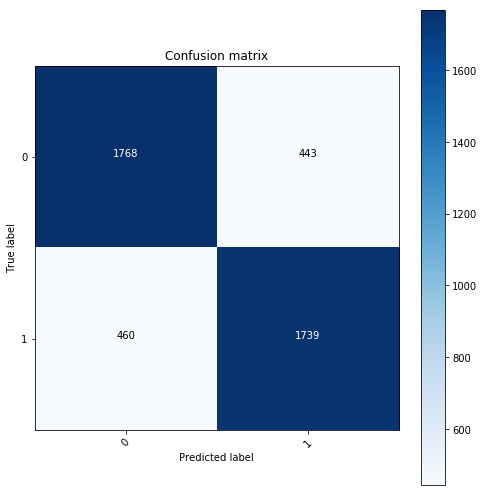

In [86]:
PlotTools.confusion_matrix(cm1, list(range(2)))

### Model Stacking:

In [115]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train, pca_lbp_train], 
                  [pca_hist_val, pca_hog_val, pca_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((17636, 50), (4410, 50))

In [116]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.8260770975056689


In [118]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((17636, 50), (4410, 50))

In [119]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.7816326530612245


In [120]:
features_train3 = None
features_val3 = None
evs = []
for ft, fv in zip([pca_kaze_train, pca_sift_train, pca_surf_train], 
                  [pca_kaze_val, pca_sift_val, pca_surf_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train3 is None:
        features_train3 = ft
        features_val3 = fv
    else:
        features_train3 = combine_features([features_train3, ft])
        features_val3 = combine_features([features_val3, fv])
features_train3.shape, features_val3.shape

((17636, 38), (4410, 38))

In [121]:
model3 = train_model(features_train3, train_y, model_name='XGB', validation=(features_val3, val_y))
prob3 = model3.predict_proba(features_val3)

Validation Accuracy in 'XGB' = 0.7639455782312925


In [93]:
prob1 = model1.predict_proba(features_val)
prob2 = model2.predict_proba(features_val)
prob3 = model3.predict_proba(features_val)
prob4 = model4.predict_proba(features_val)
#prob5 = model5.score(features_val, )
prob6 = model6.predict_proba(features_val)

In [94]:
prob = (prob1 + prob2 + prob3 + prob4 + prob6) / 5
y_hat = np.argmax(prob, axis=1)

In [95]:
metrics.accuracy_score(val_y, y_hat)

0.7839002267573696

In [200]:
y_hat = model.predict(features_val)

In [201]:
cm = MetricTools.confusion_matrix(val_y, y_hat, 20)

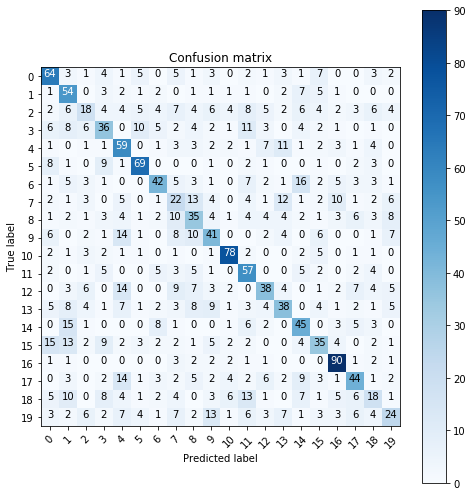

In [202]:
PlotTools.confusion_matrix(cm, list(range(20)))

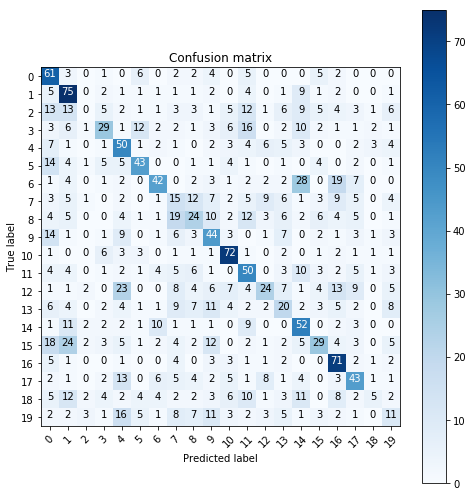

In [75]:
PlotTools.confusion_matrix(cm, list(range(20)))

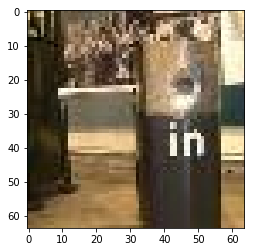

In [96]:
plt.imshow(train_imgs[train_y == 14][3])